In [57]:
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
from io import BytesIO
from sklearn.model_selection import train_test_split

# File paths


# Dataset 1 
folder_train_path = "Combined_Dataset/train/"
folder_test_path = "Combined_Dataset/test/"

# Dataset 2 
train_parquet_path = "train-00000-of-00001-c08a401c53fe5312.parquet"
test_parquet_path = "test-00000-of-00001-44110b9df98c5585.parquet"

# Output path for combined dataset
output_dir = "Combined_MRI_Dataset"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(os.path.join(output_dir, "train"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "test"), exist_ok=True)

# Settings
img_size = 128  # set 128 for now, might up to 256

# Class mapping
classes = {
    0: 'Mild_Demented',
    1: 'Moderate_Demented',
    2: 'Non_Demented',
    3: 'Very_Mild_Demented'
}

# Create class directories
for class_name in classes.values():
    os.makedirs(os.path.join(output_dir, "train", class_name), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "test", class_name), exist_ok=True)



In [59]:
# LOAD DATASET 1 (FOLDER-BASED)
def load_folder_dataset(base_dir, target_size=(img_size, img_size)):
    dataset = []
    
    # Map folder names to label system
    folder_to_label = {
        "No Impairment": 2,           # Non Demented
        "Very Mild Impairment": 3,    # Very Mild Demented
        "Mild Impairment": 0,         # Mild Demented
        "Moderate Impairment": 1      # Moderate Demented
    }
    
    for folder_name, label in folder_to_label.items():
        folder_path = os.path.join(base_dir, folder_name)
        
        if os.path.exists(folder_path):
            for img_name in os.listdir(folder_path):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(folder_path, img_name)
                    try:
                        # Load and convert image to grayscale
                        img = Image.open(img_path).convert('L')
                        
                        # Resize to standard size
                        img = img.resize(target_size)
                        
                        # Convert to numpy array and normalize
                        img_arr = np.array(img) / 255.0
                        
                        # Add to dataset
                        dataset.append({
                            'label': label,
                            'image': img_arr,
                            'source': 'folder_dataset',
                            'original_path': img_path
                        })
                        
                    except Exception as e:
                        print(f"Error loading {img_path}: {e}")
        else:
            print(f"Folder not found: {folder_path}")
    
    return dataset




In [12]:
# LOAD DATASET 2 (PARQUET-BASED) 

def bytes_to_image(img_bytes):
    nparr = np.frombuffer(img_bytes, np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
    return img

def load_parquet_data(file_path):
    dataset = []
    
    try:
        table = pq.read_table(file_path)
        df = table.to_pandas()
        
        for i, row in df.iterrows():
            img_bytes = row['image']['bytes']
            img = bytes_to_image(img_bytes)
            
            # Resize image to standard size
            img_resized = cv2.resize(img, (img_size, img_size))
            
            # Normalize pixel values to [0,1]
            img_normalized = img_resized / 255.0
            
            dataset.append({
                'image': img_normalized,
                'label': row['label'],
                'source': 'parquet_dataset'
            })
            
    except Exception as e:
        print(f"Error loading parquet file {file_path}: {e}")
    
    return dataset

In [14]:
# LOAD ALL DATASETS 

print("Loading Dataset 1 (Train)...")
folder_train_data = load_folder_dataset(folder_train_path)
print(f"Loaded {len(folder_train_data)} images from Dataset 1 Train")
# Print class distribution for Dataset 1 (Train)
class_counts = {0: 0, 1: 0, 2: 0, 3: 0}
for item in folder_train_data:
    class_counts[item['label']] += 1
print("Class distribution for Dataset 1 (Train):")
for label, count in class_counts.items():
    print(f"  {classes[label]}: {count} images")

print("\nLoading Dataset 1 (Test)...")
folder_test_data = load_folder_dataset(folder_test_path)
print(f"Loaded {len(folder_test_data)} images from Dataset 1 Test")
# Print class distribution for Dataset 1 (Test)
class_counts = {0: 0, 1: 0, 2: 0, 3: 0}
for item in folder_test_data:
    class_counts[item['label']] += 1
print("Class distribution for Dataset 1 (Test):")
for label, count in class_counts.items():
    print(f"  {classes[label]}: {count} images")

print("\nLoading Dataset 2 (Train)...")
parquet_train_data = load_parquet_data(train_parquet_path)
print(f"Loaded {len(parquet_train_data)} images from Dataset 2 Train")
# Print class distribution for Dataset 2 (Train)
class_counts = {0: 0, 1: 0, 2: 0, 3: 0}
for item in parquet_train_data:
    class_counts[item['label']] += 1
print("Class distribution for Dataset 2 (Train):")
for label, count in class_counts.items():
    print(f"  {classes[label]}: {count} images")

print("\nLoading Dataset 2 (Test)...")
parquet_test_data = load_parquet_data(test_parquet_path)
print(f"Loaded {len(parquet_test_data)} images from Dataset 2 Test")
# Print class distribution for Dataset 2 (Test)
class_counts = {0: 0, 1: 0, 2: 0, 3: 0}
for item in parquet_test_data:
    class_counts[item['label']] += 1
print("Class distribution for Dataset 2 (Test):")
for label, count in class_counts.items():
    print(f"  {classes[label]}: {count} images")



Loading Dataset 1 (Train)...
Loaded 10240 images from Dataset 1 Train
Class distribution for Dataset 1 (Train):
  Mild_Demented: 2560 images
  Moderate_Demented: 2560 images
  Non_Demented: 2560 images
  Very_Mild_Demented: 2560 images

Loading Dataset 1 (Test)...
Loaded 1279 images from Dataset 1 Test
Class distribution for Dataset 1 (Test):
  Mild_Demented: 179 images
  Moderate_Demented: 12 images
  Non_Demented: 640 images
  Very_Mild_Demented: 448 images

Loading Dataset 2 (Train)...
Loaded 5120 images from Dataset 2 Train
Class distribution for Dataset 2 (Train):
  Mild_Demented: 724 images
  Moderate_Demented: 49 images
  Non_Demented: 2566 images
  Very_Mild_Demented: 1781 images

Loading Dataset 2 (Test)...
Loaded 1280 images from Dataset 2 Test
Class distribution for Dataset 2 (Test):
  Mild_Demented: 172 images
  Moderate_Demented: 15 images
  Non_Demented: 634 images
  Very_Mild_Demented: 459 images


In [16]:
# COMBINE DATASETS 

# training data
combined_train_data = folder_train_data + parquet_train_data
print(f"Combined training data: {len(combined_train_data)} images")

# test data
combined_test_data = folder_test_data + parquet_test_data
print(f"Combined test data: {len(combined_test_data)} images")



Combined training data: 15360 images
Combined test data: 2559 images


In [18]:
# SAVE COMBINED DATASET 
def save_images(data, output_subdir):
    # Count images saved per class
    class_counts = {0: 0, 1: 0, 2: 0, 3: 0}
    
    for i, item in enumerate(data):
        label = item['label']
        img_array = item['image']
        
        # Convert back to 0-255 range for saving
        img_array_255 = (img_array * 255).astype(np.uint8)
        
        # Create PIL image
        img = Image.fromarray(img_array_255)
        
        # Generate filename
        class_name = classes[label]
        class_counts[label] += 1
        
        # Generate unique filename based on source and class count
        source_prefix = 'folder' if item.get('source') == 'folder_dataset' else 'parquet'
        filename = f"{source_prefix}_{class_name}_{class_counts[label]:04d}.png"
        
        # Save path
        save_path = os.path.join(output_dir, output_subdir, class_name, filename)
        
        # Save image
        img.save(save_path)
    
    return class_counts

print("Saving training images...")
train_counts = save_images(combined_train_data, "train")
print("Training images saved with distribution:", train_counts)

print("Saving test images...")
test_counts = save_images(combined_test_data, "test")
print("Test images saved with distribution:", test_counts)




Saving training images...
Training images saved with distribution: {0: 3284, 1: 2609, 2: 5126, 3: 4341}
Saving test images...
Test images saved with distribution: {0: 351, 1: 27, 2: 1274, 3: 907}


In [20]:
# DATASET SUMMARY 
print("\nCombined Dataset Summary:")
print(f"Total images: {len(combined_train_data) + len(combined_test_data)}")
print(f"Training images: {len(combined_train_data)}")
print(f"Test images: {len(combined_test_data)}")

print("\nClass distribution (Training):")
for label, class_name in classes.items():
    count = sum(1 for item in combined_train_data if item['label'] == label)
    print(f"{class_name}: {count} images ({count/len(combined_train_data)*100:.1f}%)")

print("\nClass distribution (Test):")
for label, class_name in classes.items():
    count = sum(1 for item in combined_test_data if item['label'] == label)
    print(f"{class_name}: {count} images ({count/len(combined_test_data)*100:.1f}%)")



Combined Dataset Summary:
Total images: 17919
Training images: 15360
Test images: 2559

Class distribution (Training):
Mild_Demented: 3284 images (21.4%)
Moderate_Demented: 2609 images (17.0%)
Non_Demented: 5126 images (33.4%)
Very_Mild_Demented: 4341 images (28.3%)

Class distribution (Test):
Mild_Demented: 351 images (13.7%)
Moderate_Demented: 27 images (1.1%)
Non_Demented: 1274 images (49.8%)
Very_Mild_Demented: 907 images (35.4%)


/var/folders/br/8_rtb5dd4ng41b3b4_j0zst80000gn/T/ipykernel_85197/3850556746.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([classes[label] for label in unique_train], rotation=45)
/var/folders/br/8_rtb5dd4ng41b3b4_j0zst80000gn/T/ipykernel_85197/3850556746.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([classes[label] for label in unique_test], rotation=45)


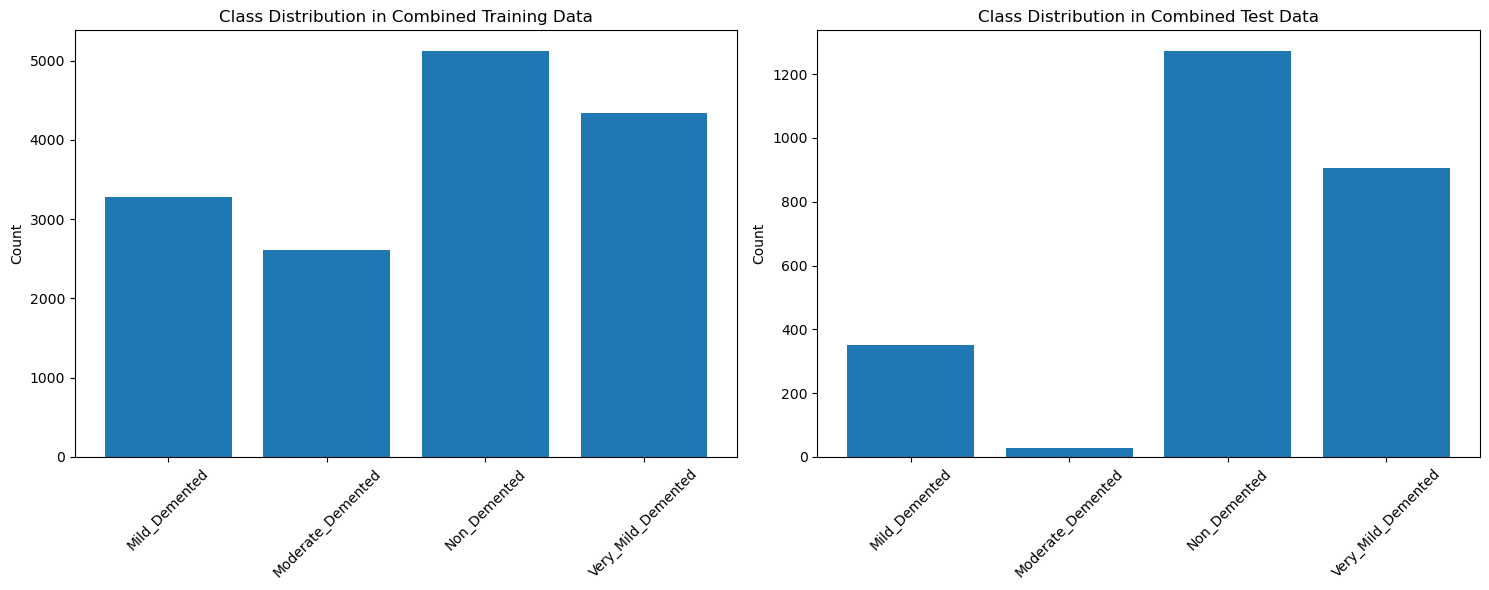

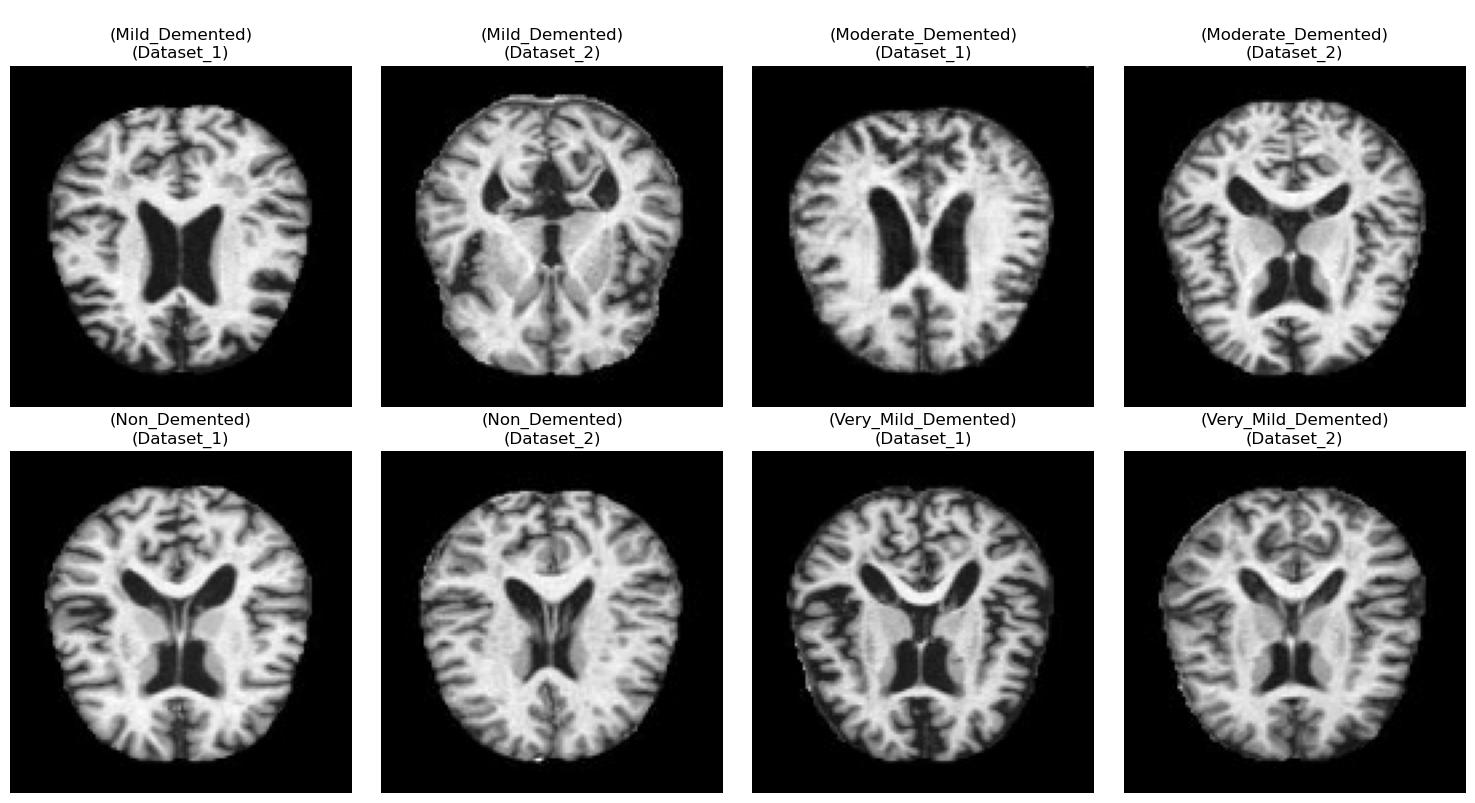

In [67]:
# VISUALIZATION 
# Visualize class distribution
def plot_class_distribution():
    train_labels = [item['label'] for item in combined_train_data]
    test_labels = [item['label'] for item in combined_test_data]
    
    unique_train, counts_train = np.unique(train_labels, return_counts=True)
    unique_test, counts_test = np.unique(test_labels, return_counts=True)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    ax1.bar([classes[label] for label in unique_train], counts_train)
    ax1.set_title('Class Distribution in Combined Training Data')
    ax1.set_ylabel('Count')
    ax1.set_xticklabels([classes[label] for label in unique_train], rotation=45)
    
    ax2.bar([classes[label] for label in unique_test], counts_test)
    ax2.set_title('Class Distribution in Combined Test Data')
    ax2.set_ylabel('Count')
    ax2.set_xticklabels([classes[label] for label in unique_test], rotation=45)
    
    plt.tight_layout()
    plt.show()  # Display the plot instead of saving it

plot_class_distribution()

# Visualize sample images
def visualize_samples():
    plt.figure(figsize=(15, 8))
    
    # Get one sample from each class for each dataset source
    samples = []
    for label in classes.keys():
        # Get a folder sample
        folder_samples = [item for item in combined_train_data 
                         if item['label'] == label and item['source'] == 'folder_dataset']
        if folder_samples:
            samples.append(folder_samples[0])
        
        # Get a parquet sample
        parquet_samples = [item for item in combined_train_data 
                          if item['label'] == label and item['source'] == 'parquet_dataset']
        if parquet_samples:
            samples.append(parquet_samples[0])
    
    # Plot samples
    for i, sample in enumerate(samples):
        plt.subplot(2, 4, i+1)
        plt.imshow(sample['image'], cmap='gray')
        source = "Dataset_1" if sample['source'] == 'folder_dataset' else "Dataset_2"
    
        plt.title(f"\n({classes[sample['label']]})\n({source})")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()  # Display the plot instead of saving it

visualize_samples()

